In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
# sklearn for preprocessing and machine learning models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
# Random seeds for consistent results
from tensorflow import set_random_seed
seed = 1234

In [2]:
data = pd.read_csv('Tweets.csv') 
print('Dataframe:')
data.head(1)

Dataframe:


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)


In [3]:
# Select features
df = data[['tweet_id', 'text', 'airline_sentiment']]
print('Feature selected DataFrame:')
df.head(2)

Feature selected DataFrame:


,tweet_id,text,airline_sentiment
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive


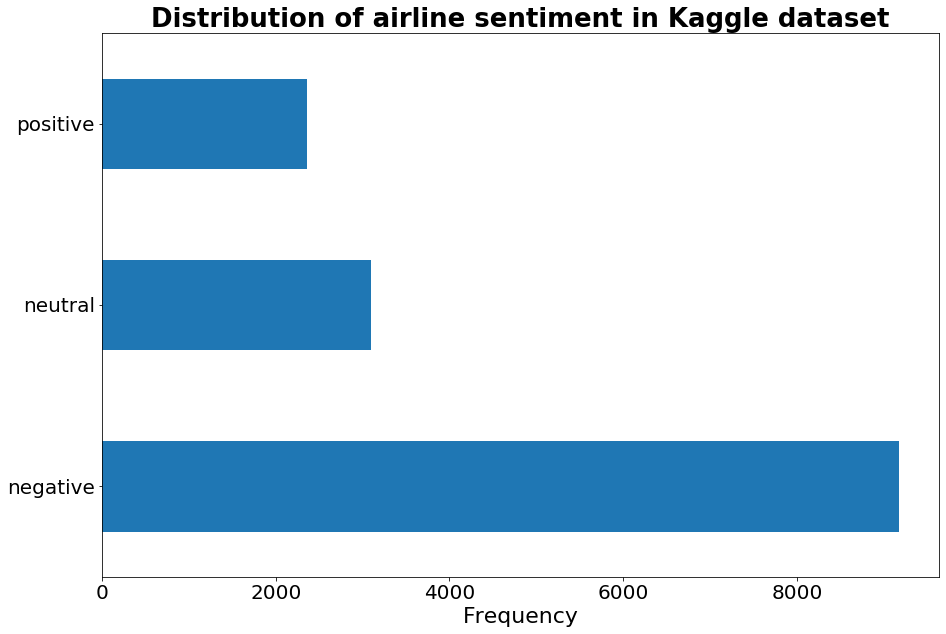

In [4]:
# Plot sentiment distribution
df['airline_sentiment'].value_counts().plot(kind = 'barh',
                                            figsize = (15,10));
plt.title('Distribution of airline sentiment in Kaggle dataset', 
          fontsize = 26, weight = 'bold')
plt.xlabel('Frequency', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

## Preprocessing

We created a preprocessor class to perform all steps that need to be performed before the text data can be vectorized. These preprocessing steps include:

Tokenization, Removing stop words, Stemming, Transform the tokens back to one string

In [5]:
class PreProcessor:
    '''
    Easily performs all the standard preprocessing steps
    like removing stopwords, stemming, etc.
    Only input that you need to provide is the dataframe and column name for the tweets
    '''
    def __init__(self, df, column_name):
        self.data = df
        self.conversations = list(self.data[column_name])
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer("english")
        self.preprocessed = []
        
    def tokenize(self, sentence):
        '''
        Splits up words and makes a list of all words in the tweet
        '''
        tokenized_sentence = word_tokenize(sentence)
        return tokenized_sentence
            
    def remove_stopwords(self, sentence):
        '''Removes stopwords like 'a', 'the', 'and', etc.'''
        filtered_sentence = []
        for w in sentence:
            if w not in self.stopwords and len(w) > 1 and w[:2] != '//' and w != 'https': 
                filtered_sentence.append(w)
        return filtered_sentence
    
    def stem(self, sentence):
        '''
        Stems certain words to their root form.
        For example, words like 'computer', 'computation'
        all get truncated to 'comput'
        '''
        return [self.stemmer.stem(word) for word in sentence]
    
    def join_to_string(self, sentence):
        '''
        Joins the tokenized words to one string.
        '''
        return ' '.join(sentence)
    
    def full_preprocess(self, n_rows=None):
        '''
        Preprocess a selected number of rows and
        connects them back to strings
        '''
        # If nothing is given do it for the whole dataset
        if n_rows == None:
            n_rows = len(self.data)
            
        # Perform preprocessing
        for i in range(n_rows):
            tweet = self.conversations[i]
            tokenized = self.tokenize(tweet)
            cleaned = self.remove_stopwords(tokenized)
            stemmed = self.stem(cleaned)
            joined = self.join_to_string(stemmed)
            self.preprocessed.append(joined)
        return self.preprocessed

In [6]:
# Preprocess text and put it in a new column
preprocessor = PreProcessor(df, 'text')
df['cleaned_text'] = preprocessor.full_preprocess()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Shuffling so we can get random tweets for the test set
df = shuffle(df, random_state=seed)
# Keep 1000 samples of the data as test set
test_set = df[:1000]

In [8]:
# Get training and validation data
X_train, X_val, y_train, y_val = train_test_split(df['cleaned_text'][1000:], 
                                                  df['airline_sentiment'][1000:], 
                                                  test_size=0.2, 
                                                  random_state=seed)

# Get sentiment labels for test set
y_test = test_set['airline_sentiment']

## Data vectorization

In [9]:
# Create matrix based on word frequency in tweets
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(test_set['cleaned_text'])

In [10]:
# Print the size of our data
print(f'Training size: {X_train.shape[0]} tweets\n\
Validation size: {X_val.shape[0]} tweets\n\
Test size: {X_test.shape[0]} tweets\n\
Amount of words (columns): {X_train.shape[1]} words')

Training size: 10912 tweets
Validation size: 2728 tweets
Test size: 1000 tweets
Amount of words (columns): 9672 words


## ML Models

### Neural Network

In [11]:
# Keras for neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [12]:
# Generator so we can easily feed batches of data to the neural network
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0]/batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

In [13]:
import numpy as np
# Onehot encoding of target variable
# Negative = [1,0,0], Neutral = [0,1,0], Positive = [0,0,1]

# Initialize sklearn's one-hot encoder class
onehot_encoder = OneHotEncoder(sparse=False)

# One hot encoding for training set
integer_encoded_train = np.array(y_train).reshape(len(y_train), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)

# One hot encoding for validation set
integer_encoded_val = np.array(y_val).reshape(len(y_val), 1)
onehot_encoded_val = onehot_encoder.fit_transform(integer_encoded_val)

In [50]:
# Neural network architecture
initializer = keras.initializers.he_normal(seed=seed)
activation = keras.activations.elu
optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)

# Build model architecture
model = Sequential()
model.add(Dense(20, activation=activation, kernel_initializer=initializer, input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax', kernel_initializer=initializer))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Hyperparameters
epochs = 20
batch_size = 32

# Fit the model using the batch_generator
hist = model.fit_generator(generator=batch_generator(X_train, onehot_encoded_train, batch_size=batch_size, shuffle=True),
                           epochs=epochs, validation_data=(X_val, onehot_encoded_val),
                           steps_per_epoch=X_train.shape[0]/batch_size, callbacks=[es])

Epoch 1/20
341/341 [==============================] - 4s 11ms/step - loss: 0.5774 - accuracy: 0.6959 - val_loss: 0.5189 - val_accuracy: 0.8051
Epoch 2/20
341/341 [==============================] - 3s 8ms/step - loss: 0.5014 - accuracy: 0.7760 - val_loss: 0.4723 - val_accuracy: 0.7857
Epoch 3/20
341/341 [==============================] - 3s 8ms/step - loss: 0.4629 - accuracy: 0.7905 - val_loss: 0.4417 - val_accuracy: 0.7995
Epoch 4/20
341/341 [==============================] - 3s 8ms/step - loss: 0.4309 - accuracy: 0.8110 - val_loss: 0.4155 - val_accuracy: 0.8137
Epoch 5/20
341/341 [==============================] - 3s 8ms/step - loss: 0.3996 - accuracy: 0.8249 - val_loss: 0.3940 - val_accuracy: 0.8247
Epoch 6/20
341/341 [==============================] - 3s 9ms/step - loss: 0.3736 - accuracy: 0.8380 - val_loss: 0.3769 - val_accuracy: 0.8324
Epoch 7/20
341/341 [==============================] - 3s 8ms/step - loss: 0.3532 - accuracy: 0.8478 - val_loss: 0.3634 - val_accuracy: 0.8388
Epoch

In [51]:
# Transform categories into numbers
# negative = 0, neutral = 1 and positive = 2
target_train = y_train.astype('category').cat.codes
target_val = y_val.astype('category').cat.codes

In [52]:
# Check results of neural network model
train_pred = [np.argmax(pred) for pred in model.predict(X_train)]
val_pred = [np.argmax(pred) for pred in model.predict(X_val)]
print(f'Accuracy on training set (NN): {round(accuracy_score(target_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (NN): {round(accuracy_score(target_val, val_pred)*100, 4)}%')

Accuracy on training set (NN): 90.7625%
Accuracy on validation set (NN): 78.9589%


In [53]:
# Neural Network predictions
nn_test_pred = [np.argmax(pred) for pred in model.predict(X_test)]
target_test = y_test.astype('category').cat.codes
print(f'Accuracy for Neural Network: {round(accuracy_score(target_test, nn_test_pred)*100, 4)}%')

Accuracy for Neural Network: 79.8%


Finally, our model has an accuracy rate of 79.8%, which is close to 80%.